In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import ast

animes_data_path = "./data/preprocessed_animes.csv"
profiles_data_path = "./data/preprocessed_profiles.csv"
reviews_data_path = "./data/preprocessed_reviews.csv"

In [ ]:
animes_data = pd.read_csv(animes_data_path)
profiles_data = pd.read_csv(profiles_data_path)
reviews_data = pd.read_csv(reviews_data_path, engine='python', sep=',', error_bad_lines=False)

<ipython-input-2-39739bd06a7d>:3: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  reviews_data = pd.read_csv(reviews_data_path, engine='python', sep=',', error_bad_lines=False)


In [ ]:
animes = animes_data.copy()
profiles = profiles_data.copy()
reviews = reviews_data.copy()

In [ ]:
import numpy as np

data = []
for review in range(0, len(reviews)):
  data.append((reviews['profile'][review], reviews['anime_uid'][review], reviews['score'][review]))

# Create mapping between original user IDs and new, ordered user IDs
unique_users = list(set([d[0] for d in data]))
user_mapping = {u: i for i, u in enumerate(unique_users)}

unique_items = list(set([d[1] for d in data]))
item_mapping = {u: i for i, u in enumerate(unique_items)}

# Create user-item rating matrix
num_users = len(profiles)
num_items = len(animes)
rating_matrix = np.zeros((num_users, num_items))
for d in data:
    user_id = d[0]
    item_id = d[1]
    rating = d[2]
    rating_matrix[user_mapping[user_id], item_mapping[item_id]] = rating


In [ ]:
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import numpy as np
train_data, test_data = train_test_split(rating_matrix, test_size=0.3, random_state=42)
train_data = torch.FloatTensor(train_data)
test_data = torch.FloatTensor(test_data)

In [ ]:
from torch.utils.data import DataLoader, TensorDataset
batchSize = 32
train_loader = DataLoader(TensorDataset(train_data), batch_size=batchSize, shuffle=True)
test_loader = DataLoader(TensorDataset(test_data), batch_size=batchSize, shuffle=True)

In [ ]:
# Load rating matrix
rating_matrix = torch.tensor(rating_matrix, dtype=torch.float32)
encoding_dim = 100
rating_diff = 9

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(num_items, encoding_dim),
            nn.ReLU())
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, num_items),
            nn.Sigmoid())

    def forward(self, x):
        encoded = self.encoder(x)
        # Sigmoid outputs 0 - 1 -> we need to scale to 1 - 10
        decoded = 9 * self.decoder(encoded) + 1
        return decoded

In [ ]:
num_users = rating_matrix.shape[0]
epochs = 20

autoencoder_model = Autoencoder()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(autoencoder_model.parameters(), lr=0.0001)
train_loss = []
test_loss = []
for epoch in range(epochs):
    autoencoder_model.train()
    running_train_loss = []
    for data in train_loader:
      optimizer.zero_grad()
      decoded = autoencoder_model(data[0])
      decoded[data[0] == 0] = 0
      loss = criterion(decoded, data[0])
      running_train_loss.append(np.sqrt(loss.detach().numpy()))
      loss.backward()
      optimizer.step()

    autoencoder_model.eval()
    running_test_loss = []
    with torch.no_grad():
        for data in test_loader:
            decoded = autoencoder_model(data[0])
            decoded[data[0] == 0] = 0
            running_test_loss.append(np.sqrt(criterion(decoded, data[0])))
    
    print('Epoch', epoch + 1, 'of', epochs, end=': ')
    print('RMSE Train Loss: {:.4f}'.format(np.mean(running_train_loss)), end=', ')
    print('RMSE Test Loss: {:.4f}'.format(np.mean(running_test_loss)))

    train_loss.append(np.mean(running_train_loss))
    test_loss.append(np.mean(running_test_loss))

Epoch 1 of 20: RMSE Train Loss: 0.0937, RMSE Test Loss: 0.0884
Epoch 2 of 20: RMSE Train Loss: 0.0839, RMSE Test Loss: 0.0806
Epoch 3 of 20: RMSE Train Loss: 0.0749, RMSE Test Loss: 0.0760
Epoch 4 of 20: RMSE Train Loss: 0.0687, RMSE Test Loss: 0.0732
Epoch 5 of 20: RMSE Train Loss: 0.0638, RMSE Test Loss: 0.0713
Epoch 6 of 20: RMSE Train Loss: 0.0601, RMSE Test Loss: 0.0697
Epoch 7 of 20: RMSE Train Loss: 0.0570, RMSE Test Loss: 0.0687
Epoch 8 of 20: RMSE Train Loss: 0.0542, RMSE Test Loss: 0.0681
Epoch 9 of 20: RMSE Train Loss: 0.0516, RMSE Test Loss: 0.0674
Epoch 10 of 20: RMSE Train Loss: 0.0494, RMSE Test Loss: 0.0670
Epoch 11 of 20: RMSE Train Loss: 0.0474, RMSE Test Loss: 0.0665
Epoch 12 of 20: RMSE Train Loss: 0.0455, RMSE Test Loss: 0.0660
Epoch 13 of 20: RMSE Train Loss: 0.0438, RMSE Test Loss: 0.0661
Epoch 14 of 20: RMSE Train Loss: 0.0422, RMSE Test Loss: 0.0657
Epoch 15 of 20: RMSE Train Loss: 0.0407, RMSE Test Loss: 0.0652
Epoch 16 of 20: RMSE Train Loss: 0.0392, RMSE Tes

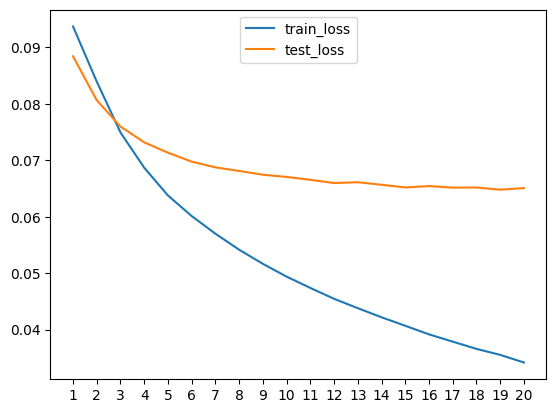

In [ ]:
import matplotlib.pyplot as plt
x = [i + 1 for i in range(epochs)]
plt.plot(x, train_loss, label='train_loss')
plt.plot(x, test_loss, label='test_loss')
leg = plt.legend(loc='upper center')
plt.xticks(x) 
plt.show()